# A Master Class in Directed Acyclic Graphs in Causal Inference

## A step-by-step explanation of Directed Acyclic Graphs from the basics to more advanced aspects

In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression


import sys
sys.path.insert(1, r'C:\Users\GHarrison\OneDrive - Lincoln College\Python Projects\Data Science\Utilities')

from Causal.lib.causal_tools2 import DirectedAcyclicGraph, scatter, scatter_intermediary
    
N : int = 1000

def scatter(x : pd.Series, y : pd.Series, color : str, title : str=""):
    r = np.corrcoef(x, y)[0, 1]

    plt.scatter(x, y, c=color, s=0.5)
    plt.xlabel(x.name)
    plt.ylabel(y.name)
    
    reg = LinearRegression().fit(x.values.reshape(-1, 1), y)
    intercept = reg.intercept_
    gradient = reg.coef_[0]
    
    x_axis = np.linspace(min(x), max(x), 100)
    y_axis = [gradient*x+intercept for x in x_axis]
    
    
    plt.title(f"{title}r={r:.2f}")
    plt.plot(x_axis, y_axis,'black')
    
def scatter_intermediary(X : pd.Series, Y : pd.Series, Z : pd.Series, SDs : float = 0.2):
    fig = plt.figure(figsize=(14, 4.5))

    plt.subplot(1, 2, 1) 
    scatter(x=X, y=Y, color="r", title=f"{X.name} vs. {Y.name}\nUnconditioned\n")

    mean_Z = Z.mean()
    std_Z = Z.std()

    low_Z = mean_Z - SDs / 2 * std_Z
    high_Z = mean_Z + SDs / 2 * std_Z

    df = pd.concat([X, Y, Z], axis=1)
    df_conditioned = df[(Z >= low_Z) & (Z <= high_Z)]
    
    conditioned_on : str = min(df_conditioned[Z.name]) if min(df_conditioned[Z.name]) == max(df_conditioned[Z.name]) else f"{min(df_conditioned[Z.name]):.1f} to {max(df_conditioned[Z.name]):.1f}"

    plt.subplot(1, 2, 2) # row 1, col 2 index 1
    scatter(x=df_conditioned[X.name], y=df_conditioned[Y.name], color="r", title=f"{X.name} vs. {Y.name}\nConditioned on {Z.name}={conditioned_on}\n")

    plt.show()


## Objective
Having spent a lot of time researching causal inference I began to realise that I did not have a full grasp of Directed Acyclic Graphs (DAGs) and that this was hampering my efforts to develop my understanding to a point where I could apply it in order to solve real-world problems.

This objective of this article is to document my learning journey and to share everything you need to know about DAGs in order to take your understanding of Causal Inference to the next level.

## Background
I would like to start by proposing a deinfition for causal inference -

"Causal inference is the process of reasoning and the application of conclusions drawn from cause-and-effect relationships between variables while taking into account potential confounding factors and biases."

That is quite a mouthful but it does encapsulate the key points -

1. It is the study of cause-and-effect.
2. The point is to draw conclusions that can be applied to solve real-world problems.
3. Any bias or "confounding" must be taken account of and compensated for.

Moving beyond the definition, there is an age old saying that "correlation does not imply causation" which leads to the question "so what does then?" 

It turns out that causation cannot be inferred or calculated from a set of data in isolation. That data needs to be extended and supplemented with additional information that can propose, visualise and represent the causal relationships and one common appraoch to the is to use a "Directed Acyclic Graph".


## A Simple DAG
At the most basic level DAGs are very simple indeed. The example below is representing the proposed relationship between taking a drug "D" and recovery "R" and the arrow is stating that taking the drug has a causal effect on recovery ...

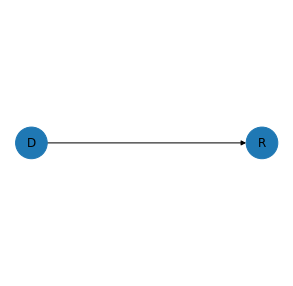

In [2]:
edges : list = [("D", "R")]
pos: dict = {"D": (1, 1), "R": (2,1)}
    
dag = DirectedAcyclicGraph(edges=edges, pos=pos, treatment="D", outcome="R")
dag.draw()

This DAG illustrates two of the key terms - "treatment" and "outcome".

- "treatment" refers to the action or intervention being studied or manipulated to determine its effect on the outcome. 
- "outcome" refers to the variable being measured to determine the effect of the treatment. 

In traditional machine learning terms the treatment is the independent variable(s) and the outcome the dependent varialble.

When I first studied DAGs I was confused by the terminology as "treatment" and "outcome" are typically medical terms and I wondered if DAGs and causal inference were limited to the medical domain. This is not the case, causal inference can be applied to any set of variables in any domain and I suspect the medical-sounding terminology has been borrowed because drug and treatment trials have a significan overlap with causal inference.

## A DAG with a "Confounder"

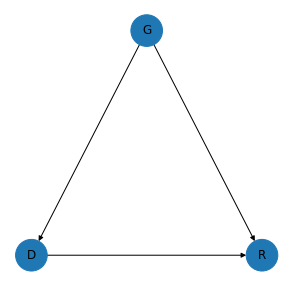

In [3]:
edges : list = [("D", "R"), ("G", "D"), ("G", "R")]
pos: dict = {"D": (1, 1), "G": (2,2), "R": (3, 1)}
    
dag = DirectedAcyclicGraph(edges=edges, pos=pos, treatment="D", outcome="R")
dag.draw()

This example adds another factor - "G" or gender. The arrows show that gender (G) has a causal affect on both the drug (D) and on recovery (R). The explanation for this is as follows -

- More males than females decide to take the drug so "Gender" causes "Drug".
- Females have a better natural recovery rate than males so "Gender" causes "Recovery".

This complicates things significantly. The objective is to establish the true effect of taking the drug on recovery but gender is affecting both so simply observing how many people in the trial took the drug and recovered does not provide an accurate answer.

This mixing effect is called "confounding" and a variable that causes this effect is a "confounder" which must be "de-confounded" to establish the true efficacy of the drug ...

## Randomized Control Trials, Stratification, Conditioning and Controlling

In order to calculate the true effect of D on R we need to isolate and remove the effect of G. There are several approaches that can be applied including the following ...

### Randomized Control Trials

If this was a future trial that was being planned, one tried-and-tested approach would be to create a "Randomized Control Trial" (RCT). This would involve randomly assigning the drug trial subjects into a test group that receives the drug and a control group that received a placebo. (Note: it is important not to tell the subjects which group they have been allocated to).

It is now impossible for gender to be causing or influencing who takes the drug because subjects are assigned randomly . This effetively "rubs out" the causal relationship between "G" and "D" which means that any observed affect of the drug on recovery will now be independent of the confounding effect - 

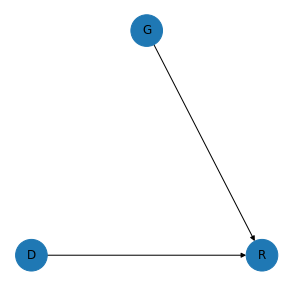

In [4]:
edges : list = [("D", "R"), ("G", "R")]
pos: dict = {"D": (1, 1), "G": (2,2), "R": (3, 1)}
    
dag = DirectedAcyclicGraph(edges=edges, pos=pos, treatment="D", outcome="R")
dag.draw()

However, if the study is based on a historical trial where the data has already been recorded it is too late to randomly assign the test and control groups and an RCT cannot be used.

Another big challenge with RCTs is that if the "treatment" being studied is smoking or obesity it is not possible to randomly assign into a smoking group or obese group so clearly there are moral and ethical boundaries that limit the applicability of RCTs.

Fortunately there are other approaches that can be applied to historical, observational data to mitigate these challenges including "stratification" ...

### Stratification

In our example, if the subjects were 60% male and 40% female the affect of the drug "D" on recovery "R" can be isolated and calculated as follows -

1. Calculate the recovery for males and multiply by 0.6 (as 60% are males).
2. Calculate the recovery for females and multiply by 0.4 (as 40% are females).
3. Add the two numbers together and this gives the affect of the drug on recovery independent from the impact of gender.

Unfortunately there are some additional challenges with stratification and similar statistical techniques.  For example, if there are a large number of causal relationships the stratification could become very complicated.

Consider the following DAG ...

- A = Parental Smoking
- B = Childhood Asthma
- C = Underlying Atopy (Unobserved)
- D = Parental Asthma
- E = Chronic Bronchitis
- F = Sex
- G = Socio-economic Status
- X = Smoking
- Y = Asthma

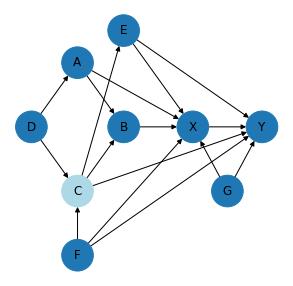

In [5]:
unobserved_confounders = ["C"]
edges : list = [("A", "B"), ("A", "X"), ("B", "X"), ("C", "E"), ("C", "B"), ("C", "Y"), ("D", "A"), ("D", "C"), ("E", "X"), ("E", "Y"), ("F", "C"), ("F", "X"), ("F", "Y"), ("G", "X"), ("G", "Y"), ("X", "Y")]
pos : dict = {"D": (1, 3), "F": (2, 1), "C": (2, 2), "A": (2, 4), "B": (3, 3), "E": (3, 4.5), "X": (4.5, 3), "G": (5.25, 2), "Y": (6, 3)}

dag = DirectedAcyclicGraph(treatment="X", outcome="Y", edges=edges, pos=pos, unobserved_confounders=unobserved_confounders)
dag.draw()

The first challenge is working out which variables to stratify on which is no easy problem to solve. It would require either someone with a lot of experience of causal relationships or a good causal inference software library, both of which are hard to find!

The second challenge is that stratification on 3 variables with 4 sub-groups in each variable requires 3 x 4 = 12 stratified groups, hence the number of samples in each becomes smaller and smaller which will decrease the confidence in the outcomes.

### Conditioning

Using causal inference techniques it is possible to simulate the affect of a real-world Randomized Control Trial on historical and observational data. 

This sounds like magic but it uses sound mathematical techniques that have been established, defined and described over many years by experts including Judea Pearl who has published his findings in academic journals and books including the following -

- The Book of Why
- Causal Inference in Statistics

This "simulation" of RCTs is achieved by applying something called <b>backfoor adjustment</b> to <b>condition</b> on all the <b>confounders</b> i.e. the variables that affect both the treatment and the outcome.

Here is the <b>backdoor adjustment formula</b> for a single treatment variable (X) on a single outcome variable (Y) with a single confounder (Z) -

$$
P(Y \mid do(X)) = \sum_{z} P(Y\mid X, Z=z)\ P(Z=z)
$$


The key takeaway is that the left hand side is describing an "intervention", for example "assign everyone to take the drug" (do(X)) which is re-written on the right hand side and expressed in terms of purely observational data.

A detailed explanation of the maths is beyond the scope of this article but if you would like to see a fully worked example, check this link out -

https://towardsdatascience.com/unlock-the-power-of-causal-inference-a-data-scientists-guide-to-understanding-backdoor-686d2826efa4

### Controlling

Controlling is a statistical technique that refers to holding the value of a variable constant that might otherwise adversely affect the outcome of a trial. 

For exmaple, in a trial that is investigating the effect of Vitamin D on alertness the designers of the trial might decide to give all participants specific instructions about their diet, when they eat, caffeine intake, screen time, exercise and alcohol intake in an attempt to isolate the true effect.

There seems to be some healthy disagreement in the literature at this point. Statisticians often seem to control for everything they can, even in a Randomized Control Trial.

Proponents of causal inference in general and Judea Pearl in particular seem to advocate only controlling (or conditioning) on those variables that are specifically confounding the effect of the treatment on the outcome.

I do share Pearl's view that controlling for everything in a trial may not be necessary and may even have unintended negative consequences on the results. My reasoning is that in a Randomized Control Trial any external factors like caffeine intake etc. should average out within and across the groups because of the random selection of the participants and also how do we know for sure that the participants followed the instructions?

Also the theory of Causal Inference does make a strong case for identifying an optimum set of variables to condition on and to limit the adjustments accordingly (more on this later).

## Recap
At this point we have defined causal inference, explored the purpose of DAGs and explained confounders, RCTs, stratification, conditioning and controlling.

RCTs, stratification and controlling are all statistical technqiues related to real-world trials. 

Conditioning is a causal inference technique that can be applied to historical, obervational data to draw conclusions about the affect of a treatment on an outcome even where the participants of the original survey were not selected at random.

This instantly opens up a world of opportunity because there are lots of historical, observational datasets that can now be explored for cause-and-effect and this is just one of the many benefits of causal inference and directed acyclic graphs.

Armed with this understanding and terminolofgy we are now ready to explore and the more complex aspects of DAGs which are often not explained clearly in the available books and online articles ...

## Paths
The next subject to explore is paths. When I began my exploration of the literature I was very confused by the different approaches to visualising causality. Sometimes the books show DAGs like the ones we have already seen and sometimes they show the relationships in a more "flattened" form like $D \leftarrow G \rightarrow R$ and I did not understand the difference.

Consider the following hypothetical Directed Acyclic Graph ...

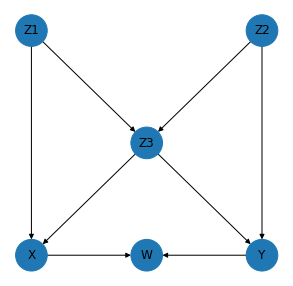

In [6]:
edges : list = [('Z1', 'Z3'),  ('Z1', 'X'),  ('Z3', 'X'), ('Z3', 'Y'), ('X', 'W'), ('Z2', 'Z3'), ('Z2', 'Y'), ('Y', 'W')]
pos : dict = {'X':(1, 1), 'W':(2, 1), 'Y':(3, 1), 'Z1':(1, 3), 'Z3':(2, 2), 'Z2':(3, 3)}
    
dag = DirectedAcyclicGraph(treatment="X", outcome="Y", edges=edges, pos=pos)

dag.draw()

This is more complicated that the drug, gender, recovery example but quite staright-forward once the key concept of <b>paths</b> has been unpacked. I have not managed to find a definitive definition of "path" in the literature, so here is my interpretation ...

A path is a sequence of causal links connecting the treatment and the outcome in a causal diagram.

In the above DAG, therfore, a single path is -  $X \leftarrow Z1 \rightarrow Z3 \rightarrow Y$.

Initially this is unituitive because we are used to thinking of natural paths flowing directionally from left to right like $A \rightarrow B \rightarrow C$ but I would ask you to suspend that intuitive view. In causal diagrams the direction of the arrows does not matter, any set of edges from X to Y constitutes a path.

Once that point is fully understood the difference between DAGs and the flattened form like $D \leftarrow G \rightarrow R$ becomes obvious.

A Directed Acyclic Graph is a single visualisation of a set of causal relationships which contains a number of paths. Whenever the literature examines the flattened form it is looking at a single path that must exist with other to describe all the causal relationships.

To illustrate this explanation here is a list of all the "flattened" paths that exists within the example DAG ...

In [7]:
dag.print_paths(dag.all_paths(), display_latex=True)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

An alternative visualisation to the flat view is to highlight every path on a separate copy of the DAG as in the following example ...

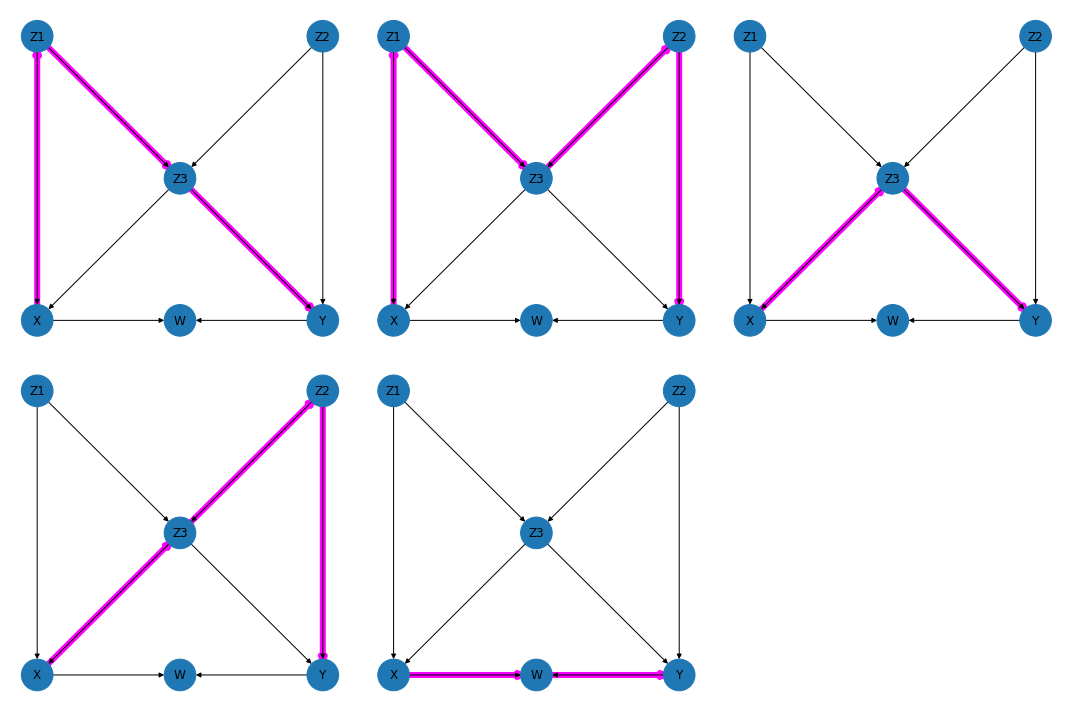

In [8]:
dag.draw_paths(paths=dag.all_paths())

Once these key points have been unpacked, paths are not very difficult to understand. I often wonder if the authors of the available books and articles are so familiar with and expert in their subjects that they overlook how it feels to be building an understanding from the beginners perspective.

Visualising DAGs and paths like this certainly helped me to build an reasonable understanding and that is critical to moving onto the next stage ...

## Forks, Chains and Colliders
If a path contains any two nodes are connected via an <b>intermediary</b> i.e. a node in-between then there are precisely patterns by which those nodes can be connected and those patters are a fork, a chain and a collider.

### Forks
Forks are a familiar pattern as the relationship between drug (D), recovery (R) and gender (G) describe this pattern. Note that in the context of paths. 

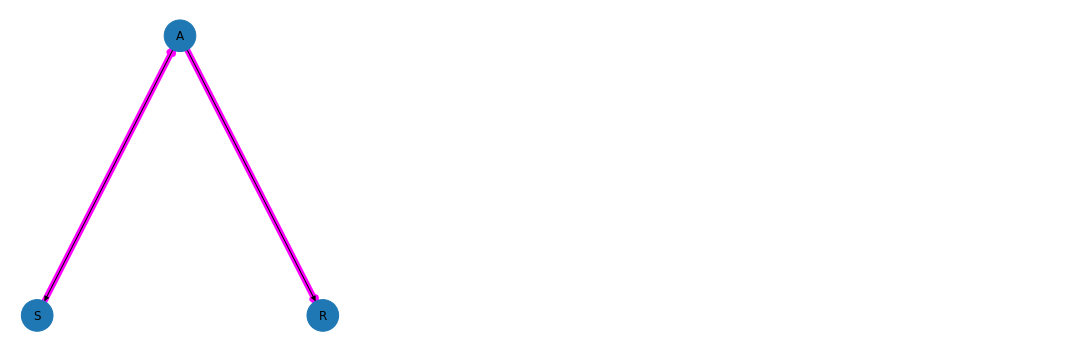

<IPython.core.display.Math object>

In [9]:
edges : list = [("A", "S"), ("A", "R")]
pos: dict = {"S": (1, 1), "A": (2,2), "R": (3, 1)}
    
dag = DirectedAcyclicGraph(edges=edges, pos=pos, treatment="S", outcome="R")
dag.draw_paths(dag.backdoor_paths())
plt.show()
dag.print_paths(dag.backdoor_paths(), display_latex=True)

This example represents the causal relationships between childrens' ages (A), shoe-size (S) and reading ability (R). It is a "fork" because the path forks off in two different directions from the intermediary variable A.

The rules of causal inference state that the path from S to R through A is open and that information about S can make its way over to R through the confounder A unless we "condition" on A in which case the path is <b>blocked</b>.

This rule confused me for a long time, but it is easily explained by looking at a practical example with some data.

The synthetic dataset below contains 1000 data points for S, A and R ...

In [10]:
# Data for Age, Shoe Size, Reading Ability example
np.random.seed(42)

fS = lambda age: 2 * age + 2  + np.random.normal(loc=0, scale=1, size=1)[0]
fR = lambda age: 1.5 * age + 20  + np.random.normal(loc=0, scale=1, size=1)[0]

df = pd.DataFrame()

df["Age"] = np.random.uniform(4, 12, N).round()

df["Shoe Size"] = df["Age"].apply(fS).mul(2).round().div(2)
df["Reading Ability"] = df["Age"].apply(fR)

df = df[["Shoe Size", "Age", "Reading Ability"]]
df

,Shoe Size,Age,Reading Ability
0,16.0,7.0,29.093683
1,24.5,12.0,37.916894
2,22.5,10.0,33.495280
3,20.5,9.0,34.260056
4,12.5,5.0,27.582440
...,...,...,...
995,10.5,5.0,27.215125
996,23.5,11.0,36.243820
997,12.0,5.0,27.258503
998,25.5,12.0,37.938236


The dataset is encapsulating the causality described in the DAG so we would expect a correlation between age and shoe size and also between age and reading ability. Here are 2 scatter plots that visualise  these associations ...

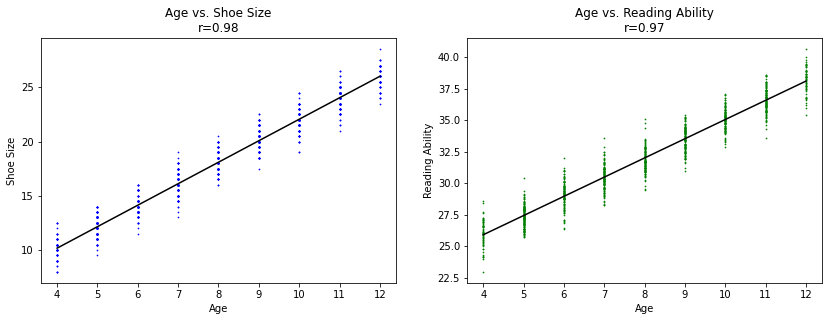

In [11]:
fig = plt.figure(figsize=(14, 4.5))

plt.subplot(1, 2, 1) 
scatter(x=df["Age"], y=df["Shoe Size"], color="b", title="Age vs. Shoe Size\n")

plt.subplot(1, 2, 2) 
scatter(x=df["Age"], y=df["Reading Ability"], color="g", title="Age vs. Reading Ability\n")

Sure enough they are closely correlated with r scores of 0.97 and 0.93 respectively. But what happens when we look at the correlation between shoe size and reading ability? There is no causal link but we will still see a correlation because age is having a <b>confounding</b> effect.

This apparently enables reading ability to be predicted from age, but buying larger shoes will not make anyone more intelligent or vice versa. 

The concept of conditioning to "block" the path can easily be visualised by fixing of on a single value for age and looking at the scatter plot ...

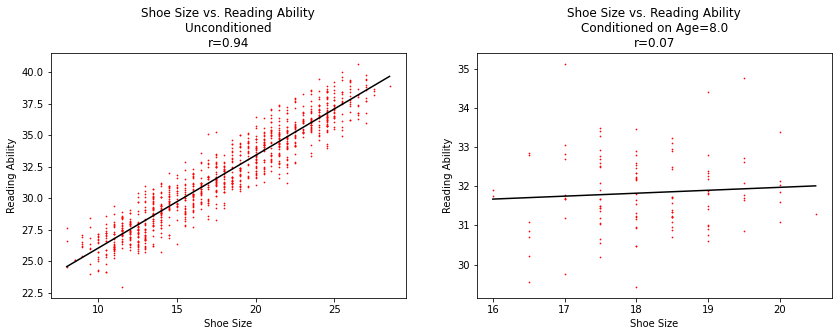

In [12]:
scatter_intermediary(X=df["Shoe Size"], Y=df["Reading Ability"], Z=df["Age"])

This is conditioning and blocking in action. When age is conditioned by filtering to just the 9 year-olds the regression line is flat with an r value of 0.03. It is no longer possible to pick a shoe size and then read across to a estimate the reading ability.

The act of "conditioning" on the confounder "age" has blocked the association between shoe size and reading ability.

Conditioning on an intermediary node in a fork <b>blocks</b> the path and not conditioning on it leaves it <b>unblocked</b> and open.

### Chains
Chains are the simplest pattern between two nodes through an intermediary; the first variable causes the intermediary and the intermediary causes the final variable.

When we say that conditioning on B blocks the path from A to C in a causal diagram A -> B -> C, we mean that if we measure the value of B and include it as a variable in a statistical model, then the direct effect of A on C is no longer present in the model. This is true even if A and C remain correlated after conditioning on B.

In the causal diagram A -> B -> C, the variable B acts as a mediator or intermediate variable between A and C. Conditioning on B means that we hold its value constant, so any effect of A on C that is transmitted solely through B is removed from the statistical model. This is why conditioning on B blocks the path from A to C.

However, if there is still an indirect effect of A on C that is not mediated by B, then A and C may remain correlated even after conditioning on B. In this case, conditioning on B will remove the direct effect of A on C that is transmitted through B, but it will not remove the indirect effect of A on C that is not mediated by B.

In [13]:
np.random.seed(42)

fB = lambda drug: 1.5 * drug + 10 + np.random.normal(loc=0, scale=1, size=1)[0]
fR = lambda bp: -1.5 * bp + 32 + np.random.normal(loc=0, scale=1, size=1)[0]

df = pd.DataFrame()

df["Drug"] = np.random.uniform(0, 5, N)
df["Blood Pressure"] = df["Drug"].apply(fB)
df["Recovery"] = df["Blood Pressure"].apply(fR)

df

,Drug,Blood Pressure,Recovery
0,1.872701,12.986752,11.113555
1,4.753572,15.795013,8.224375
2,3.659970,15.870152,6.690051
3,2.993292,15.100524,10.109269
4,0.780093,11.729930,14.487544
...,...,...,...
995,0.457910,9.366843,17.664860
996,4.586568,16.268083,7.341696
997,0.684093,10.989103,15.274848
998,4.751187,16.697478,6.892019


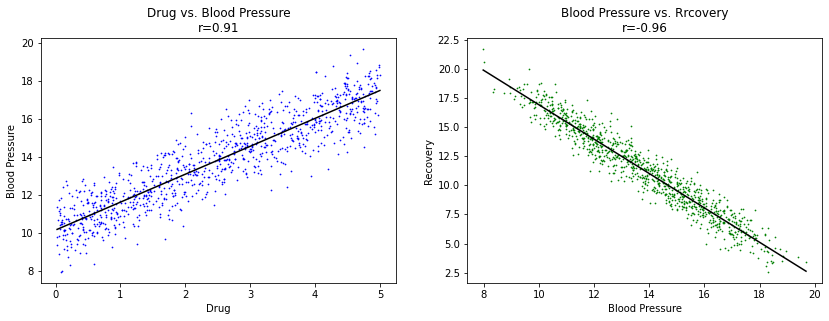

In [14]:
fig = plt.figure(figsize=(14, 4.5))

plt.subplot(1, 2, 1) 
scatter(x=df["Drug"], y=df["Blood Pressure"], color="b", title="Drug vs. Blood Pressure\n")

plt.subplot(1, 2, 2) 
scatter(x=df["Blood Pressure"], y=df["Recovery"], color="g", title="Blood Pressure vs. Rrcovery\n")  

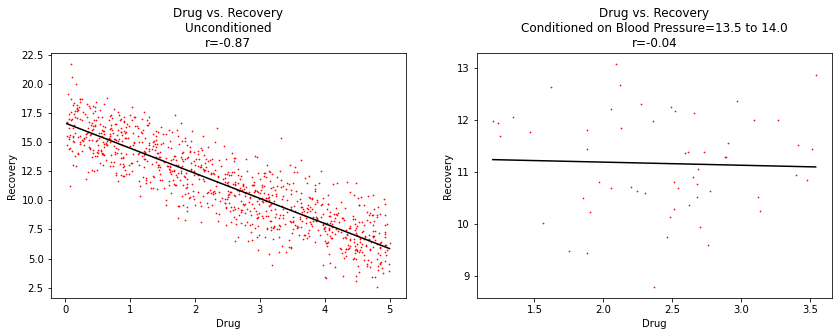

In [15]:
scatter_intermediary(X=df["Drug"], Y=df["Recovery"], Z=df["Blood Pressure"])

Yes, if you condition on the mediator (i.e., the intermediate variable) in a causal chain, you should observe a weaker or no correlation between the treatment and outcome variables in the conditioned data compared to the unconditioned data. This is because conditioning on the mediator blocks the direct effect of the treatment on the outcome, leaving only the indirect effect that operates through the mediator. If the mediator is not strongly correlated with the treatment or the outcome, then the indirect effect may be weaker, resulting in a weaker or no correlation between the treatment and outcome in the conditioned data. However, the degree to which the correlation is weakened will depend on the strength of the relationship between the treatment, mediator, and outcome variables, as well as any other confounding factors that may be present.

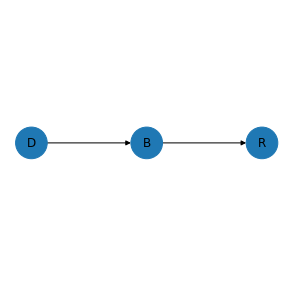

<IPython.core.display.Math object>

In [16]:
edges : list = [("D", "B"), ("B", "R")]
pos: dict = {"D": (1, 1), "B": (2, 1), "R": (3, 1)}
    
dag = DirectedAcyclicGraph(edges=edges, pos=pos, treatment="D", outcome="R")
dag.draw()
plt.show()
dag.print_paths(dag.all_paths(), display_latex=True)

This example represents a drug (D) having a causal impact on blood pressure (B) which in turn has a causal relationship on patient recovery (R).

The drug does not directly cause recovery, so there is no direct arrow from D to R, nor does the drug affect R through any other variable (like for example lowering the patients temperature or reducing inflammation etc.).

If we were to look at a dataset and filter just for rows where blood pressure is "very low" we 

This DAG represents the following causal relationships -

1. Taking the drug (D) causes blood pressure (B) to change.
2. A change in blood pressure (B) causes recovery (R) to change.

i.e. The drug does not cause recovery directly, rather the drug impacts on blood pressure which then impacts on recovery.

This third pattern is a collider - 

### Colliders

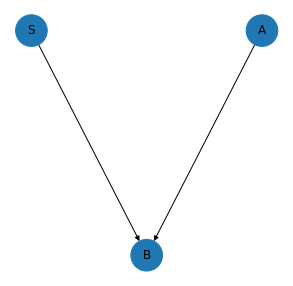

<IPython.core.display.Math object>

In [17]:
edges : list = [("S", "B"), ("A", "B")]
pos: dict = {"S": (1, 2), "B": (2, 1), "A": (3, 2)}
    
dag = DirectedAcyclicGraph(edges=edges, pos=pos, treatment="S", outcome="A")
dag.draw()
plt.show()
dag.print_paths(dag.all_paths(), display_latex=True)

This DAG represents the following causal relationships in a hypothetical college that specialises in sport -

1. Sporting ability (S) causes the award of student bursaries (B).
2. Academic ability (A) also causes the award of student bursaries (B).

A frontdoor path is any path from X to Y that passes through a mediator or set of mediators M, where M blocks all backdoor paths from X to Y, and there are no unblocked paths from X to M.

?????

In [18]:
np.random.seed(42)

df = pd.DataFrame()

fSS = lambda sa, aa : 1.05 * sa + 0.95 * aa  + np.random.normal(loc=0, scale=1, size=1)[0]

df["Sports Ability"] = np.random.normal(5, 2, N)
df["Academic Ability"] = np.random.normal(5, 2, N)
df["Scholarship Score"] = df.apply(lambda row: fSS(row["Sports Ability"], row["Academic Ability"]), axis=1)

df = df[["Sports Ability", "Scholarship Score", "Academic Ability"]]
df

,Sports Ability,Scholarship Score,Academic Ability
0,5.993428,13.026697,7.798711
1,4.723471,11.321930,6.849267
2,6.295377,10.681024,5.119261
3,8.046060,11.661221,3.706126
4,4.531693,8.941288,6.396447
...,...,...,...
995,4.437799,11.520455,7.140300
996,8.595373,13.982504,4.946957
997,6.281686,8.428448,3.236251
998,3.857642,8.824873,4.673866


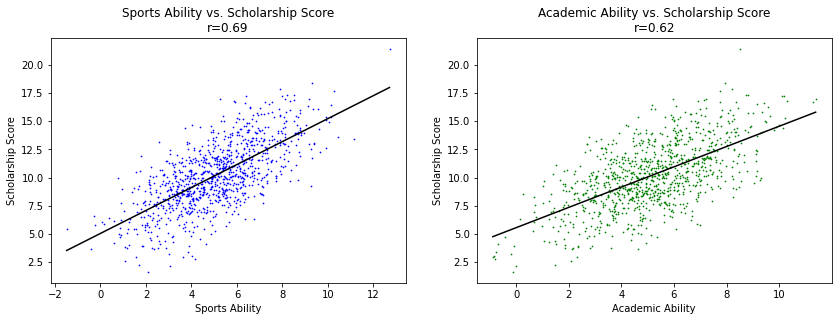

In [19]:
fig = plt.figure(figsize=(14, 4.5))

plt.subplot(1, 2, 1) 
scatter(x=df["Sports Ability"], y=df["Scholarship Score"], color="b", title="Sports Ability vs. Scholarship Score\n")

plt.subplot(1, 2, 2) 
scatter(x=df["Academic Ability"], y=df["Scholarship Score"], color="g", title="Academic Ability vs. Scholarship Score\n")

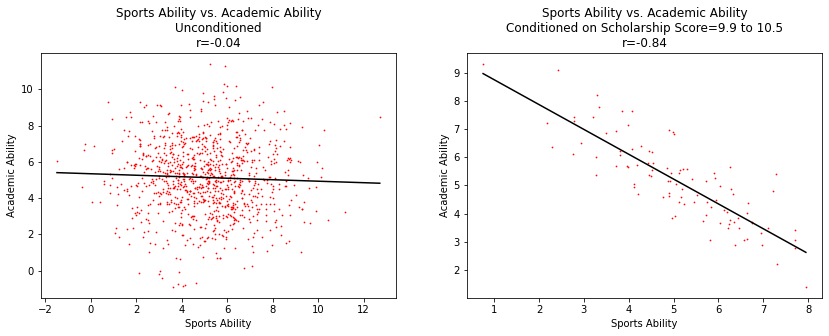

In [20]:
scatter_intermediary(X=df["Sports Ability"], Y=df["Academic Ability"], Z=df["Scholarship Score"])